# Audio Visual Reaction Time Simulation
This notebook use the decision making model by Wang and colleagues to simuate multisensry reaction time task.
To simulate adu

In [1]:
from platform import python_version

print(python_version())

3.8.8


## Material and Methods
### The two-variable network model

### Calling Library Fuctions

In [1]:
# LIBRARY

import numpy as np # vector manipulation
import math  # math functions
import sys
import pandas as pd
from scipy.stats import ttest_ind
# THIS IS FOR PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import warnings
warnings.filterwarnings("ignore")


### The Reduced Network Model

In [2]:
def H(x):
    a=270 # Hz/nA
    b=108 # Hz
    d=.154 # seconds
    f=(a*x-b)/(1-np.exp(-d*(a*x-b)))
    return f
x=np.arange(-1,1,0.01)


### Neural Circuit
$$ x_{1}=J_{11}S_1-J_{12}S_2+J_{13}S_3-J_{14}S_4+I_{0}+I_{1}+I_{noise,1}$$
$$ x_{2}=J_{22}S_2-J_{21}S_1+I_{0}+I_{2}+I_{noise,1}$$

where the synaptic couplings are $J_{11}=0.2609$, $J_{22}=0.2609$, $J_{12}=0.0497$ and $J_{21}=0.0497$.
$I_{0}=0.3255 nA$ represents external input 


In [3]:
def total_synaptic_current(S_1,S_2,S_3,S_4,I_1,I_2,I_noise_1,I_noise_2):
    # Synaptic coupling
    J_11=0.2609 # nA
    J_22=0.2609 # nA
    J_13=0*0.000497/np.sqrt(2) # nA
    J_24=0*0.000497/np.sqrt(2) # nA
  
    J_12=0.0497 # nA
    J_21=0.0497 # nA
    I_0=0.3255  # nA
    x_1=J_11*S_1-J_12*S_2+J_13*S_3+I_0+I_1+I_noise_1
    x_2=J_22*S_2-J_21*S_1+J_24*S_4+I_0+I_2+I_noise_2
    return x_1, x_2


### Background activity
$$ \tau_{AMPA}\frac{d I_{noise,i}(t)}{dt} =-I_{noise,i}(t)+\eta_i(t)\sqrt{\tau_{AMPA}}\sigma_{noise}$$

In [4]:
def Background_Activity(I_noise):
    h=0.1
    sigma_noise=0.02 # nA
    tau_AMPA=2 #ms
    eta_noise=np.random.normal(0,1,1)
    k=0#(-(I_noise)+eta_noise*np.sqrt(tau_AMPA)*sigma_noise)
    I_noise_new=I_noise+h/tau_AMPA*(-(I_noise+h/2*k)+eta_noise
                                *np.sqrt(tau_AMPA)*sigma_noise)
    return I_noise_new

### Network Dynamics
$$ \frac{d S_{i}}{dt} =-\frac{S_{i}}{\tau_S}+(1-S_{i})\gamma H_{i}$$

In [5]:
def Network_Dynamics_VIS(S,x):
    h=0.1/1000 #ms
    gamma=0.641
    tau_S=.100 #s
    k=(-S/tau_S+(1-S)*gamma*H(x)/1)
    S_new=S+h*(-(S+h/2*k)/tau_S+(1-S+h/2*k)*gamma*H(x))
    return S_new

def Network_Dynamics_AUDIO(S,x):
    h=0.1/1000 #ms
    gamma=0.641
    #tau_S=.10 #s
    tau_S=.100 #s
    k=(-S/tau_S+(1-S)*gamma*H(x)/1)
    S_new=S+h*(-(S+h/2*k)/tau_S+(1-S+h/2*k)*gamma*H(x))
    return S_new

### Input Current Target

$$ I_i=J_{A,ext}\mu_0\left(1+ \frac{c'}{100} \right) $$


In [6]:
def I_input_1(c_dash):
    J_A_ext=5.2/10000 # nA/Hz
    mu_0=30 # Hz
    I_motion=J_A_ext*mu_0*(1+(c_dash)/100)
    return I_motion

$$ I_2=J_{A,ext}\mu_0\left(1- \frac{c'}{100} \right) $$

In [7]:
def I_input_2(c_dash):
    J_A_ext=0.00052 # nA/Hz
    mu_0=30 # Hz
    I_motion=J_A_ext*mu_0*(1-(c_dash)/100)
    return I_motion

In [8]:
        
def Reaction_Time_MULT(Firing_Rate_1,Firing_Rate_2,Firing_Rate_3,Firing_Rate_4,Threshold,time):
    ANSWER=0
    RT=0
    count=0
    if (Firing_Rate_1>=Threshold )| (Firing_Rate_3 >=Threshold): 
        ANSWER=1
        RT=time
        count=1
    elif (Firing_Rate_2>=Threshold)|(Firing_Rate_4 >=Threshold):
        ANSWER=0
        RT=time
        count=1
    return ANSWER,RT,count

In [9]:
def Reaction_Time_UNI(Firing_Rate_1,Firing_Rate_2,Threshold,time):
    ANSWER=0
    RT=0
    count=0
    if (Firing_Rate_1>=Threshold ): 
        ANSWER=1
        RT=time
        count=1
    elif (Firing_Rate_2>=Threshold):
        ANSWER=0
        RT=time
        count=1
    return ANSWER,RT,count

In [10]:
h=0.1
time=np.arange(-100,1500,h)
J_A_ext=0.00052 # nA/Hz
mu_0=30 # Hz
STIMULUS=[10.0]#,7.5,10.0,15.0]


Threshold=20
N=100


ALL_F_1=0.2*np.ones((N,len(time)))
ALL_F_2=0.2*np.ones((N,len(time)))
I_VIS_EXCITE=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
I_VIS_INHIB=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
Firing_target_VIS_EXCITE=0*time # np.zeros((1,len(time)))
Firing_target_VIS_INHIB=0*time # np.zeros((1,len(time)))
Firing_target_AUDIO_EXCITE=0*time # np.zeros((1,len(time)))
Firing_target_AUDIO_INHIB=0*time # np.zeros((1,len(time)))

In [11]:
RT_AUDIO_coh_hit=[]
RT_AUDIO_coh_miss=[]#np.zeros(len(Vector_coherence))
Prob_AUDIO=[]#np.zeros(len(Vector_coherence))
RT_VIS_coh_hit=[]#np.zeros(len(Vector_coherence))
RT_VIS_coh_miss=[]#np.zeros(len(Vector_coherence))
Prob_VIS=[]#np.zeros(len(Vector_coherence))



j=0
#for j in range(0,len(Vector_coherence)):
for k in range(0,1):
  
    ANSWER_VIS=np.zeros(N)
    RT_VIS=np.zeros(N)
    ANSWER_AUDIO=np.zeros(N)
    RT_AUDIO=np.zeros(N)
    ANSWER_AV=np.zeros(N)
    RT_AV=np.zeros(N)




    for n in range(0,N):
        if n%50==0:
            print(' n: %d' %(n))
        I_noise_VIS_EXCITE=0.001*np.random.normal(0,1,len(time))
        I_noise_VIS_INHIB=0.001*np.random.normal(0,1,len(time))

        x_VIS_EXCITE=J_A_ext*mu_0*np.random.uniform(0,1,len(time))
        x_VIS_INHIB=J_A_ext*mu_0*np.random.uniform(0,1,len(time))
        x_AUDIO_EXCITE=J_A_ext*mu_0*np.random.uniform(0,1,len(time))
        x_AUDIO_INHIB=J_A_ext*mu_0*np.random.uniform(0,1,len(time))


        S_VIS_EXCITE=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time))
        S_VIS_INHIB=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time)) 
        S_AUDIO_EXCITE=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time))
        S_AUDIO_INHIB=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time)) 


 

        Firing_target_VIS_EXCITE[0]=H(x_VIS_EXCITE[0])
        Firing_target_VIS_INHIB[0]=H(x_VIS_INHIB[0])
        Firing_target_AUDIO_EXCITE[0]=H(x_VIS_EXCITE[0])
        Firing_target_AUDIO_INHIB[0]=H(x_VIS_INHIB[0])



        count_AUDIO=0

        count_VIS=0
        count_AV=0
        for i in range (0,len(time)-1):
            if time[i] >=0 and time[i]<1000:
                c_dash=STIMULUS[0]
            else:
                c_dash=0.0

        
            I_noise_VIS_EXCITE[i+1]=Background_Activity(I_noise_VIS_EXCITE[i])
            I_noise_VIS_INHIB[i+1]=Background_Activity(I_noise_VIS_INHIB[i])

            I_VIS_EXCITE[i+1]=I_input_1(c_dash)
            I_VIS_INHIB[i+1]=I_input_1(-c_dash)

            x_VIS_EXCITE[i+1],x_VIS_INHIB[i+1]=total_synaptic_current(S_VIS_EXCITE[i],S_VIS_INHIB[i],S_AUDIO_EXCITE[i],S_AUDIO_INHIB[i],I_VIS_EXCITE[i],I_VIS_INHIB[i],I_noise_VIS_EXCITE[i],I_noise_VIS_INHIB[i])
            S_VIS_EXCITE[i+1]=Network_Dynamics_VIS(S_VIS_EXCITE[i],x_VIS_EXCITE[i+1])
            S_VIS_INHIB[i+1]=Network_Dynamics_VIS(S_VIS_INHIB[i],x_VIS_INHIB[i+1])
            Firing_target_VIS_EXCITE[i+1]=H(x_VIS_EXCITE[i+1])
            Firing_target_VIS_INHIB[i+1]=H(x_VIS_INHIB[i+1])
            
            I_noise_VIS_EXCITE[i+1]=Background_Activity(I_noise_VIS_EXCITE[i])
            I_noise_VIS_INHIB[i+1]=Background_Activity(I_noise_VIS_INHIB[i])
            x_AUDIO_EXCITE[i+1],x_AUDIO_INHIB[i+1]=total_synaptic_current(S_AUDIO_EXCITE[i],S_AUDIO_INHIB[i],S_VIS_EXCITE[i],S_VIS_INHIB[i],I_VIS_EXCITE[i],I_VIS_INHIB[i],I_noise_VIS_EXCITE[i],I_noise_VIS_INHIB[i])
            S_AUDIO_EXCITE[i+1]=Network_Dynamics_AUDIO(S_AUDIO_EXCITE[i],x_AUDIO_EXCITE[i+1])
            S_AUDIO_INHIB[i+1]=Network_Dynamics_AUDIO(S_AUDIO_INHIB[i],x_AUDIO_INHIB[i+1])
            Firing_target_AUDIO_EXCITE[i+1]=H(x_AUDIO_EXCITE[i+1])
            Firing_target_AUDIO_INHIB[i+1]=H(x_AUDIO_INHIB[i+1])
            
            
            if count_AV <0.5:
                ANSWER_AV[n],RT_AV[n],count_AV=Reaction_Time_MULT(Firing_target_VIS_EXCITE[i],Firing_target_VIS_INHIB[i],Firing_target_AUDIO_EXCITE[i],Firing_target_AUDIO_INHIB[i],Threshold,time[i])
            if count_VIS <0.5:
                ANSWER_VIS[n],RT_VIS[n],count_VIS=Reaction_Time_UNI(Firing_target_VIS_EXCITE[i],Firing_target_VIS_INHIB[i],Threshold,time[i])
            if count_AUDIO <0.5:
                ANSWER_AUDIO[n],RT_AUDIO[n],count_AUDIO=Reaction_Time_UNI(Firing_target_AUDIO_EXCITE[i],Firing_target_AUDIO_INHIB[i],Threshold,time[i])



            
    
#   RT_VIS_coh_hit.append(np.average(RT_VIS[ANSWER_VIS==1]))
#    RT_VIS_coh_miss.append(np.average(RT_VIS[ANSWER_VIS==0]))
#    Prob_VIS.append(np.average(ANSWER_VIS))
#    RT_AUDIO_coh_hit.append(np.average(RT_AUDIO[ANSWER_AUDIO==1]))
#    RT_AUDIO_coh_miss.append(np.average(RT_AUDIO[ANSWER_AUDIO==0]))
#    Prob_AUDIO.append(np.average(ANSWER_AUDIO))

 n: 0
 n: 50


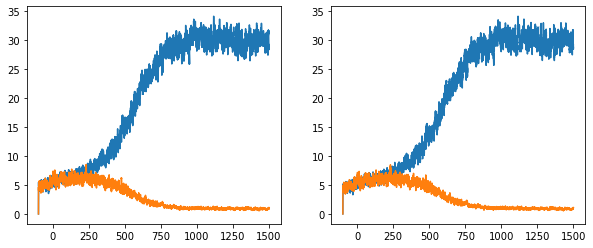

In [12]:
fig = plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(time,Firing_target_AUDIO_EXCITE.T)
plt.plot(time,Firing_target_AUDIO_INHIB.T)
plt.subplot(122)
plt.plot(time,Firing_target_VIS_EXCITE.T)
plt.plot(time,Firing_target_VIS_INHIB.T)
plt.show()

### Plotting
#### Input

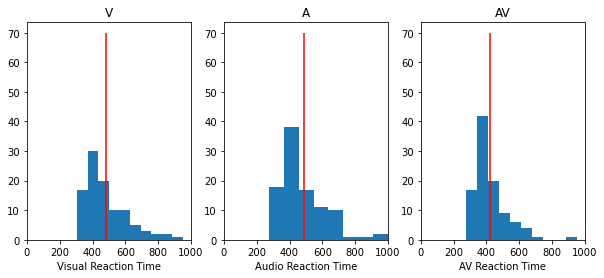

490.2129999999665
478.9949999999671


422.50099999997025

In [13]:
fig = plt.figure(figsize=(10,4))
plt.subplot(131)
plt.hist(RT_VIS)
plt.vlines(np.mean(RT_VIS),0,70,color='red')
plt.xlim(0,1000)

plt.xlabel('Visual Reaction Time')
plt.title('V')


plt.subplot(132)
plt.hist(RT_AUDIO)
plt.xlabel('Audio Reaction Time')
plt.vlines(np.mean(RT_AUDIO),0,70,color='red')
plt.xlim(0,1000)



plt.title('A')

plt.subplot(133)
plt.hist(RT_AV)
plt.vlines(np.mean(RT_AV),0,70,color='red')
plt.xlabel('AV Reaction Time')
plt.title('AV')
plt.xlim(0,1000)


plt.savefig('AV_Behavioural.png', bbox_inches='tight',dpi=300)
plt.show()
print(np.mean(RT_AUDIO))
print(np.mean(RT_VIS))

np.mean(RT_AV)


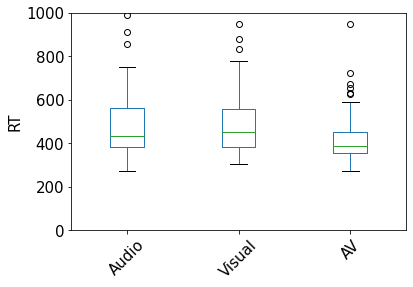

Ttest_indResult(statistic=3.3549286654200987, pvalue=0.0009514310078025887)

In [14]:
df=pd.DataFrame({'Audio': RT_AUDIO, 'Visual': RT_VIS,'AV':RT_AV})
#from matplotlib import pyplot as plt

fig = plt.figure(figsize=(6,4))
ax=df.boxplot(grid=False, rot=45, fontsize=15)
#fig.set_ylabel('RT')
ax.set_ylabel('RT', fontsize=15)
ax.set_ylim((0,1000))
#df.boxplot(grid=False, rot=45, fontsize=15)
plt.show()


ttest_ind(df['Visual'],df['AV'])

In [15]:
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['Audio', 'Visual', 'AV'])
# replace column names
df_melt.columns = ['index', 'condition', 'RT']

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('RT ~ C(condition)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(condition),2.634110e+05,2.0,6.936184,0.001137
Residual,5.639490e+06,297.0,NaN,NaN


## Reference
Fearon, C., Butler, J. S., Newman, L., Lynch, T., & Reilly, R. B. (2015). Audiovisual processing is abnormal in Parkinson’s disease and correlates with freezing of gait and disease duration. Journal of Parkinson's disease, 5(4), 925-936.